In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import zipfile
import pandas as pd
import numpy as np
tf.__version__

'2.13.0'

In [3]:
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification -p Datasets_Collection/Coronavirus_Tweets_Classification

covid-19-nlp-text-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
dataset_dir = os.path.join(os.getcwd(), "Datasets_Collection", "Coronavirus_Tweets_Classification")
os.makedirs(dataset_dir, exist_ok = True)

In [5]:
zip_found = False
for filename in os.listdir(dataset_dir):
    if filename.endswith(".zip"):
        dataset_zip_name = filename
        zip_found = True
        break

if not zip_found:
    raise FileNotFoundError()

In [6]:
with zipfile.ZipFile(os.path.join(dataset_dir, dataset_zip_name), 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

In [42]:
train_val_df = pd.read_csv(os.path.join(dataset_dir, "Corona_NLP_train.csv"), encoding = "ISO-8859-1")
test_df = pd.read_csv(os.path.join(dataset_dir, "Corona_NLP_test.csv"), encoding = "ISO-8859-1")
# print(test_df)

In [43]:
class_names = train_val_df['Sentiment'].unique()
classes_count = len(class_names)
class_names

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [44]:
class_names_dict = dict()
for i, class_name in enumerate(class_names):
    class_names_dict[class_name] = i
print(class_names_dict)

{'Neutral': 0, 'Positive': 1, 'Extremely Negative': 2, 'Negative': 3, 'Extremely Positive': 4}


In [45]:
test_df['Sentiment'].map(class_names_dict)

0       2
1       1
2       4
3       3
4       0
       ..
3793    1
3794    3
3795    0
3796    2
3797    4
Name: Sentiment, Length: 3798, dtype: int64

In [46]:
train_val_df = train_val_df[['OriginalTweet', 'Sentiment']]
train_val_df['Sentiment'] = train_val_df['Sentiment'].map(class_names_dict)
test_df = test_df[['OriginalTweet', 'Sentiment']]
test_df['Sentiment'] = test_df['Sentiment'].map(class_names_dict)
test_df


,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,2
1,When I couldn't find hand sanitizer at Fred Me...,1
2,Find out how you can protect yourself and love...,4
3,#Panic buying hits #NewYork City as anxious sh...,3
4,#toiletpaper #dunnypaper #coronavirus #coronav...,0
...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,1
3794,Did you panic buy a lot of non-perishable item...,3
3795,Asst Prof of Economics @cconces was on @NBCPhi...,0
3796,Gov need to do somethings instead of biar je r...,2


In [47]:
train_data_len = int(len(train_val_df)*80/100)

train_df = train_val_df[:train_data_len]
val_df = train_val_df[train_data_len:]

In [141]:
def make_raw_ds(df: pd.DataFrame):
    return tf.data.Dataset.from_tensor_slices((df['OriginalTweet'].values, df['Sentiment'].values))

In [142]:
raw_train_ds = make_raw_ds(train_df)
raw_val_ds = make_raw_ds(val_df)
raw_test_ds = make_raw_ds(test_df)
raw_train_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [143]:
for x, y in raw_train_ds.take(1):
  print(x)

tf.Tensor(b'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8', shape=(), dtype=string)


In [144]:
max_tokens = 10000
sequence_length = 200

vectorized_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=sequence_length
)

In [145]:
get_text_from_ds = lambda x, y: x

train_ds_text = raw_train_ds.map(get_text_from_ds)
train_ds_text

<_MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [146]:
vectorized_layer.adapt(train_ds_text)

In [147]:
vectorized_layer("This is the text")

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([  16,   11,    2, 2050,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [148]:
def make_ds(text, label):
  return vectorized_layer(text), label

In [149]:
unbatched_train_ds = raw_train_ds.map(make_ds)
unbatched_val_ds = raw_val_ds.map(make_ds)
unbatched_test_ds = raw_test_ds.map(make_ds)
# train_ds = make_ds(raw_train_ds)
# val_ds = make_ds(raw_val_ds)
unbatched_train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [150]:
for x, y in unbatched_train_ds.take(1):
    print(x)

tf.Tensor(
[1 1 1 1 4 1 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(200,), dtype=int64)


In [89]:
batch_size = 8
epochs = 4

In [151]:
train_ds = unbatched_train_ds.batch(batch_size)
val_ds = unbatched_val_ds.batch(batch_size)
test_ds = unbatched_test_ds.batch(batch_size)
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [152]:
for x, y in train_ds.take(1):
    print(x)

tf.Tensor(
[[   1    1    1 ...    0    0    0]
 [ 517  971    3 ...    0    0    0]
 [   8  818 1677 ...    0    0    0]
 ...
 [  27  198    5 ...    0    0    0]
 [1181   18   23 ...    0    0    0]
 [  72   18    2 ...    0    0    0]], shape=(8, 200), dtype=int64)


In [153]:
embedding_dim = 32

inputs = tf.keras.layers.Input(shape=(sequence_length,))
x = tf.keras.layers.Embedding(max_tokens + 1, embedding_dim)(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
outputs = tf.keras.layers.Dense(classes_count, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="sentiment_model_1")
model.summary()

Model: "sentiment_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 200, 32)           320032    
                                                                 
 dropout_7 (Dropout)         (None, 200, 32)           0         
                                                                 
 global_average_pooling1d_3  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                 

In [154]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [155]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    # batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/10
4116/4116 [==============================] - 27s 7ms/step - loss: 1.4876 - sparse_categorical_accuracy: 0.3237 - val_loss: 1.2954 - val_sparse_categorical_accuracy: 0.4541
Epoch 2/10
4116/4116 [==============================] - 30s 7ms/step - loss: 1.1347 - sparse_categorical_accuracy: 0.5307 - val_loss: 1.0137 - val_sparse_categorical_accuracy: 0.6036
Epoch 3/10
4116/4116 [==============================] - 30s 7ms/step - loss: 0.9132 - sparse_categorical_accuracy: 0.6492 - val_loss: 0.9014 - val_sparse_categorical_accuracy: 0.6627
Epoch 4/10
4116/4116 [==============================] - 30s 7ms/step - loss: 0.7965 - sparse_categorical_accuracy: 0.7106 - val_loss: 0.8538 - val_sparse_categorical_accuracy: 0.6859
Epoch 5/10
4116/4116 [==============================] - 29s 7ms/step - loss: 0.7197 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.8302 - val_sparse_categorical_accuracy: 0.6963
Epoch 6/10
4116/4116 [==============================] - 30s 7ms/step - loss: 0.6639 -

In [156]:
hist = history.history
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


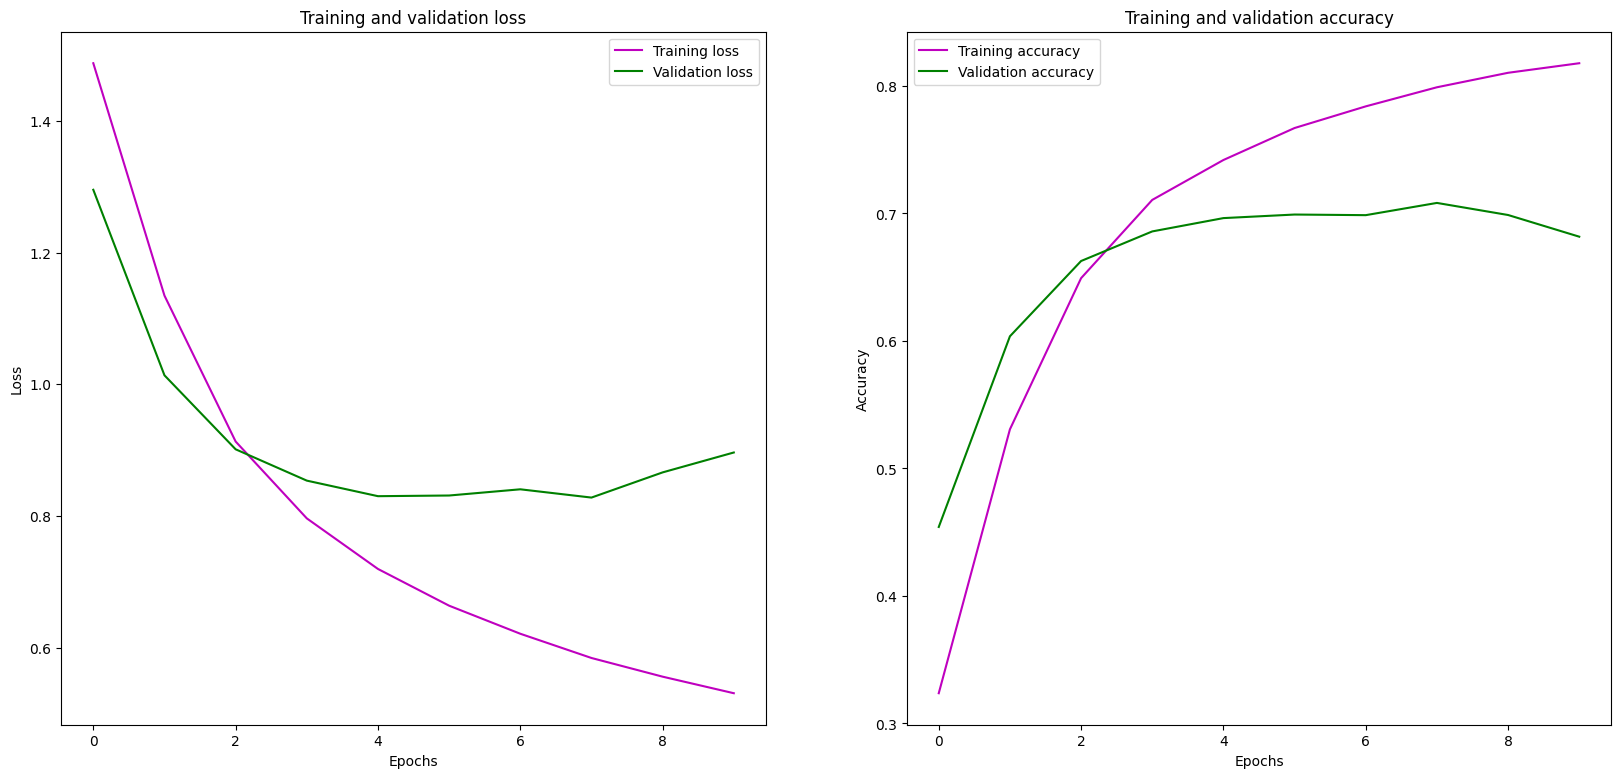

In [157]:
epochs_limit = 500

if epochs_limit > epochs:
    epoch_limit = epochs

plt.figure(figsize=(20, 9))

plt.subplot(1,2,1)
plt.plot(hist["loss"][:epochs_limit], 'm', label='Training loss')
plt.plot(hist["val_loss"][:epochs_limit], color='g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist["sparse_categorical_accuracy"][:epochs_limit], 'm', label='Training accuracy')
plt.plot(hist["val_sparse_categorical_accuracy"][:epochs_limit], 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [158]:
loss, acc = model.evaluate(test_ds)

print(f"{loss = }")
print(f"{acc = }")

475/475 [==============================] - 1s 1ms/step - loss: 1.0003 - sparse_categorical_accuracy: 0.6567
loss = 1.000349998474121
acc = 0.6566613912582397


In [163]:
vectorized_layer("this is bad")

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([ 16,  11, 473,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  

In [194]:
# model.summary()
pred = model.predict(np.array([vectorized_layer("people are happy but in trouble")]))
class_names[np.argmax(pred[0])]

1/1 [==============================] - 0s 19ms/step


'Positive'

## With Flatten
* with single dropout
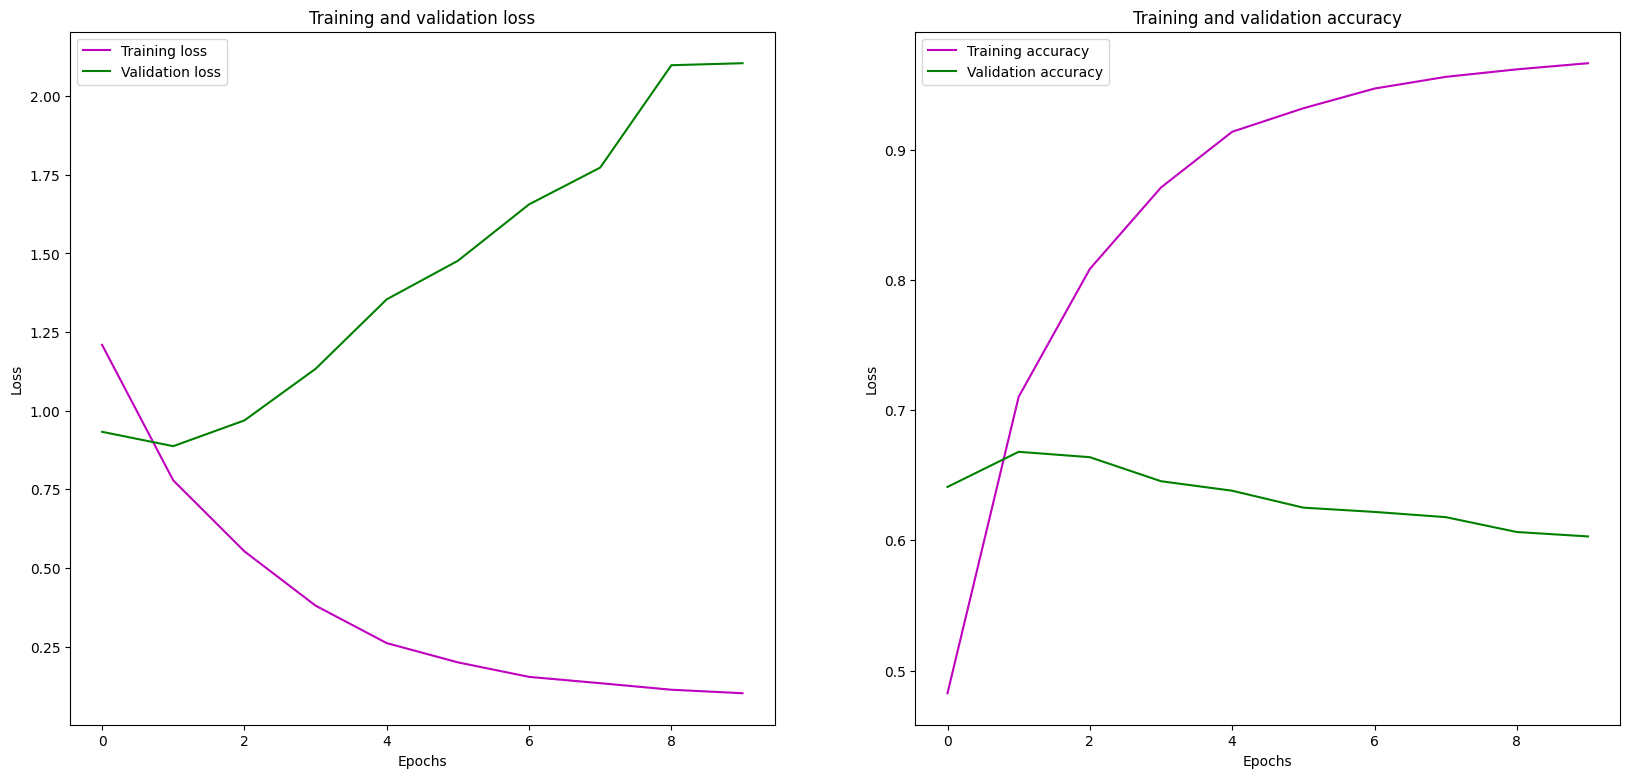

## With GlobalAveragePooling1D
* with single dropout
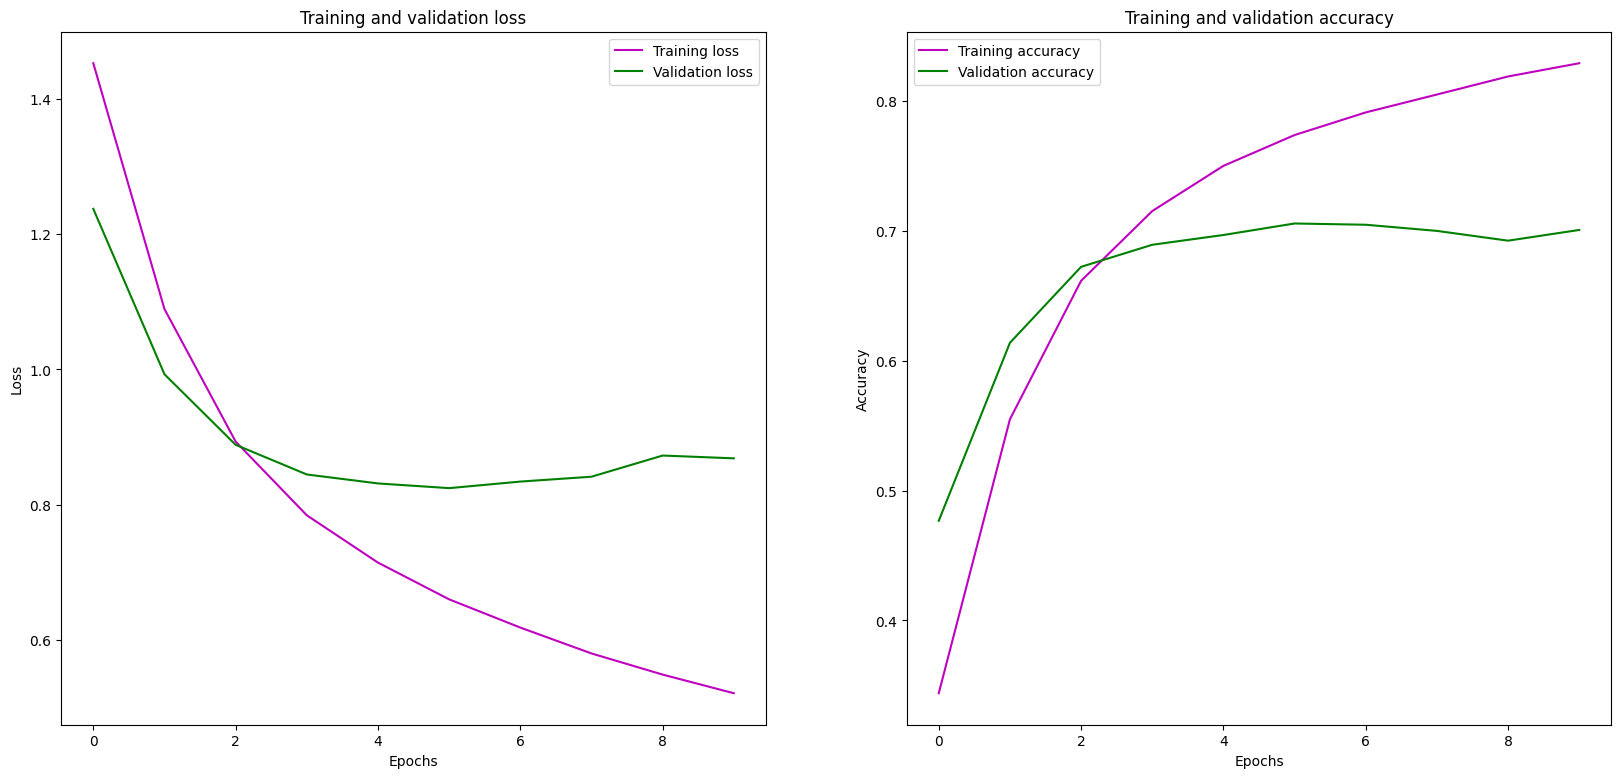

## With GlobalAveragePooling1D
* with double dropout
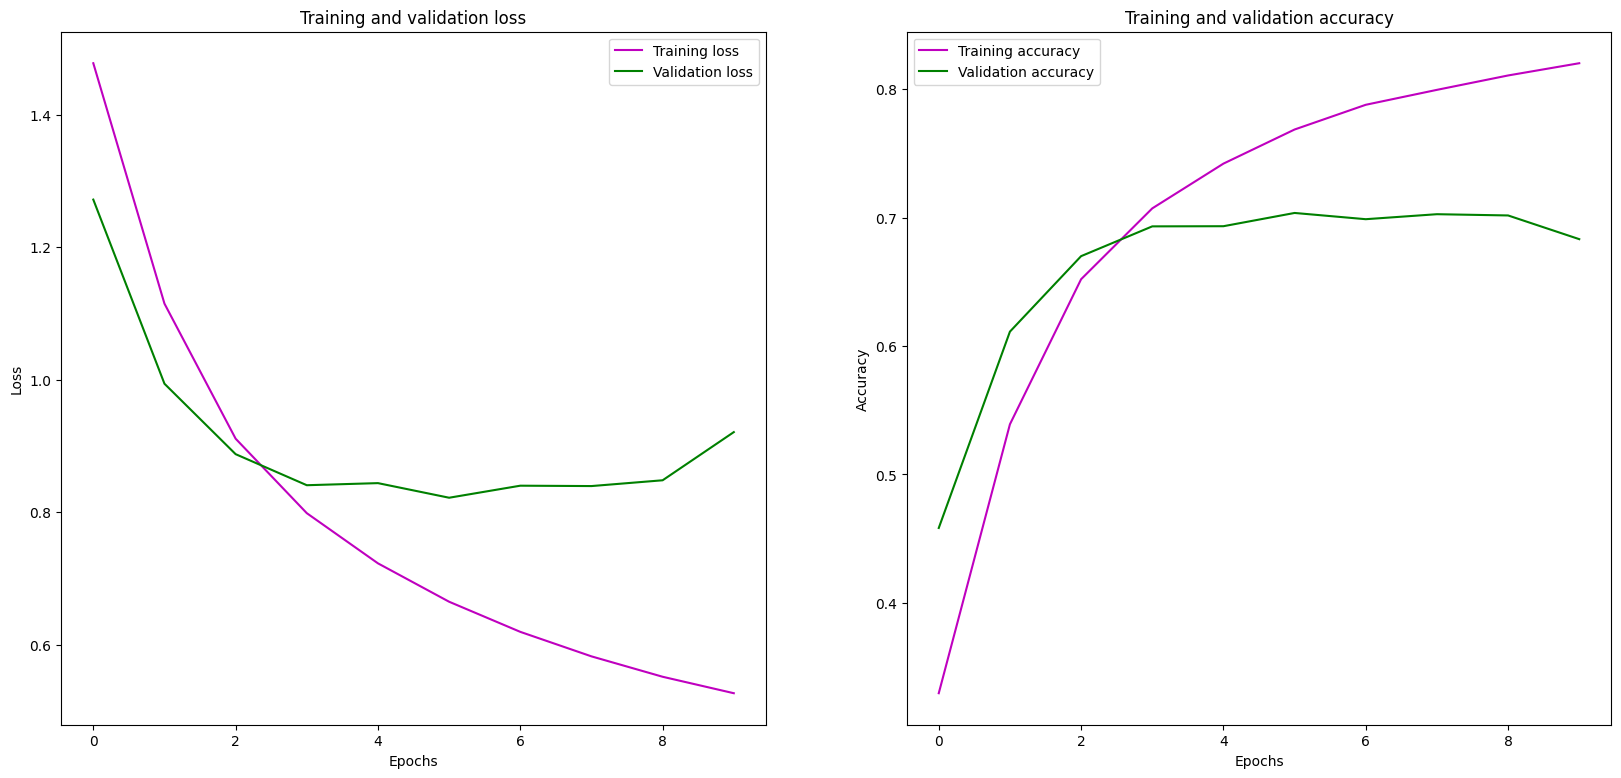